---

## **Proyecto: Predicción de Desembarques Pesqueros en Tierra del Fuego**



---
### **Índice**
1. [Importación y Limpieza de Datos](#1-importación-y-limpieza-de-datos)
2. [Exploración y Análisis de Datos (EDA)](#2-exploración-y-análisis-de-datos)
3. [Ingeniería de Características (Feature Engineering)](#3-ingeniería-de-características)
4. [Selección y Entrenamiento del Modelo](#4-selección-y-entrenamiento-del-modelo)
5. [Evaluación del Modelo](#5-evaluación-del-modelo)
6. [Visualización de Resultados](#6-visualización-de-resultados)
7. [Conclusión](#7-conclusión)
8. [Guardar el Modelo Entrenado](#8-guardar-el-modelo-entrenado)
9. [Referencias y Bibliografía](#9-Referencias-y-Bibliografía)
---

### **1. Importación de Librerías**

Primero, importamos las librerías necesarias para el análisis. He eliminado las importaciones redundantes y no utilizadas para mantener el código limpio.



In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns


**Explicación:**

- `pandas`: Para manipular y analizar estructuras de datos.
- `numpy`: Para operaciones numéricas eficientes.
- `matplotlib` y `seaborn`: Para crear visualizaciones atractivas.
- `%matplotlib inline`: Para mostrar las gráficas directamente en el notebook.
- `plt.style.use('seaborn-darkgrid')`: Para establecer un estilo consistente en las gráficas.

---

### ** Carga y Exploración Inicial del Dataset**

#### **1.1 Carga del Dataset**

Cargamos el archivo CSV asegurándonos de manejar correctamente la codificación de caracteres.

In [70]:
# Ruta del archivo CSV
ruta_csv = 'desembarques_raw.csv'

# Intentamos cargar el dataset con diferentes codificaciones si es necesario
try:
    df = pd.read_csv(ruta_csv, encoding='latin-1')
except UnicodeDecodeError:
    df = pd.read_csv(ruta_csv, encoding='ISO-8859-1')
except Exception as e:
    print(f"Error al leer el archivo CSV: {e}")

**Nota:** Asegúrate de que el archivo `desembarques_raw.csv` está en el mismo directorio que tu notebook o proporciona la ruta correcta.

#### **1.2 Exploración Inicial**

Visualizamos las primeras filas y obtenemos información general del DataFrame.

In [71]:
# Visualizar las primeras 5 filas
df.head()

,año,mes,total,ushuaia,almanza
0,1990,Enero,4938.8,4938.8,0
1,1990,Febrero,166.7,166.7,0
2,1990,Marzo,29.4,29.4,0
3,1990,Abril,3290.9,3290.9,0
4,1990,Mayo,756.1,756.1,0


In [72]:
# Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   año      404 non-null    int64 
 1   mes      404 non-null    object
 2   total    404 non-null    object
 3   ushuaia  404 non-null    object
 4   almanza  403 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.9+ KB


**Explicación:**

- `df.head()`: Nos permite ver las primeras filas y entender la estructura de los datos.
- `df.info()`: Proporciona información sobre el número de entradas, tipos de datos y valores nulos.

---

### **Limpieza y Preprocesamiento de Datos**

#### **1.3 Conversión de Tipos de Datos**

Observamos que algunas columnas numéricas pueden estar almacenadas como objetos (strings). Convertimos estas columnas a tipos numéricos.


In [73]:
# Listado de columnas que deben ser numéricas
columnas_numericas = ['total', 'ushuaia', 'almanza']

# Convertir las columnas a tipo numérico
for columna in columnas_numericas:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')

**Explicación:**

- Usamos `pd.to_numeric()` con `errors='coerce'` para convertir los valores no numéricos a `NaN`, lo que nos permitirá identificarlos y manejarlos posteriormente.

#### **1.4 Manejo de Valores Nulos**

Verificamos si hay valores nulos en las columnas numéricas y decidimos cómo manejarlos.

In [74]:
# Contar valores nulos en las columnas numéricas
df[columnas_numericas].isnull().sum()

,0
total,3
ushuaia,3
almanza,10


**Supongamos que encontramos valores nulos en 'almanza' y 'ushuaia'.**

**Imputación de Valores Nulos:**

- Si un valor nulo en 'almanza' o 'ushuaia' significa que no hubo desembarques en ese puerto ese mes, podemos reemplazar los `NaN` por 0.

In [75]:
# Reemplazar valores nulos en 'almanza' y 'ushuaia' por 0
df['almanza'] = df['almanza'].fillna(0)
df['ushuaia'] = df['ushuaia'].fillna(0)

- Si 'total' es nulo pero tenemos valores en 'almanza' y 'ushuaia', podemos recalcular 'total' sumando estas dos columnas.

In [76]:
# Recalcular 'total' cuando es nulo
df['total'] = df.apply(
    lambda row: row['ushuaia'] + row['almanza'] if pd.isnull(row['total']) else row['total'],
    axis=1
)

- Si aún quedan valores nulos en 'total', podemos decidir cómo manejarlos. Por ejemplo, podríamos rellenarlos con la mediana o eliminarlos.

In [77]:
# Rellenar valores nulos en 'total' con la mediana
df['total'] = df['total'].fillna(df['total'].median())

#### **1.5 Verificación de Valores Nulos**

Confirmamos que ya no hay valores nulos en las columnas numéricas.

In [78]:
# Verificar valores nulos nuevamente
df[columnas_numericas].isnull().sum()

,0
total,0
ushuaia,0
almanza,0


#### **1.6 Limpieza y Formateo de la Columna 'mes'**

Estandarizamos los nombres de los meses y corregimos posibles errores tipográficos.

In [79]:
# Convertir a minúsculas y eliminar espacios en blanco
df['mes'] = df['mes'].str.lower().str.strip()

# Corregir errores comunes en los nombres de los meses
df['mes'] = df['mes'].replace({
    'setiembre': 'septiembre',
    'marzo ': 'marzo',  # Ejemplo de espacio adicional
    # Agrega más correcciones si es necesario
})

#### **1.7 Conversión de 'mes' a Número**

Creamos un diccionario para mapear los nombres de los meses a números.


In [80]:
# Diccionario de mapeo de meses
meses = {
    'enero': 1,
    'febrero': 2,
    'marzo': 3,
    'abril': 4,
    'mayo': 5,
    'junio': 6,
    'julio': 7,
    'agosto': 8,
    'septiembre': 9,
    'octubre': 10,
    'noviembre': 11,
    'diciembre': 12
}

# Mapear los nombres de los meses a números
df['mes_num'] = df['mes'].map(meses)

#### **1.8 Conversión de 'año' a Numérico**

Aseguramos que la columna 'año' sea de tipo numérico.

In [81]:
df['año'] = pd.to_numeric(df['año'], errors='coerce')

#### **1.9 Creación de la Columna 'fecha'**

Combinamos 'año' y 'mes_num' para crear una columna de tipo fecha.

In [82]:
# Asegurarnos de que 'año' y 'mes_num' son de tipo entero
df['año'] = df['año'].astype(int)
df['mes_num'] = df['mes_num'].astype(int)

# Crear la columna 'fecha' utilizando pd.to_datetime
df['fecha'] = pd.to_datetime(df['año'].astype(str) + '-' + df['mes_num'].astype(str) + '-01', format='%Y-%m-%d', errors='coerce')

# Verificar si la columna 'fecha' fue creada correctamente
print(df[['año', 'mes_num', 'fecha']].head())



    año  mes_num      fecha
0  1990        1 1990-01-01
1  1990        2 1990-02-01
2  1990        3 1990-03-01
3  1990        4 1990-04-01
4  1990        5 1990-05-01


#### **1.10 Manejo de Valores Nulos en 'fecha'**

Verificamos si hay valores nulos en 'fecha' y los manejamos.

In [83]:
# Verificar valores nulos en 'fecha'
df['fecha'].isnull().sum()

0

Si hay valores nulos en 'fecha', probablemente se deban a valores faltantes o incorrectos en 'año' o 'mes_num'. Podemos decidir eliminar estas filas o imputar los valores faltantes si es posible.

**Eliminar filas con fechas nulas:**

In [84]:
# Eliminar filas con fechas nulas
df = df.dropna(subset=['fecha'])

#### **1.11 Ordenar el DataFrame por 'fecha'**

Ordenamos el DataFrame para mantener el orden cronológico.


In [85]:
# Ordenar por 'fecha'
df = df.sort_values('fecha').reset_index(drop=True)

#### **1.12 Verificación Final**

Revisamos que todas las columnas estén en el formato correcto y que no haya valores nulos inesperados.


In [86]:
# Información final del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   año      404 non-null    int64         
 1   mes      404 non-null    object        
 2   total    404 non-null    float64       
 3   ushuaia  404 non-null    float64       
 4   almanza  404 non-null    float64       
 5   mes_num  404 non-null    int64         
 6   fecha    404 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 22.2+ KB


---

### **2. Exploración y Análisis de Datos (EDA)**

Ahora que tenemos los datos limpios, exploraremos el dataset para entender mejor las tendencias y patrones presentes.

#### **2.1 Estadísticas Descriptivas**

Obtenemos estadísticas básicas de las variables numéricas.

In [87]:
# Estadísticas descriptivas
df.describe()

,año,total,ushuaia,almanza,mes_num,fecha
count,404.000000,404.000000,404.000000,404.000000,404.000000,404
mean,2006.336634,6974.607366,6974.027785,0.579582,6.460396,2006-10-16 07:43:21.980198144
min,1990.000000,0.000000,0.000000,0.000000,1.000000,1990-01-01 00:00:00
25%,1998.000000,3081.066500,3079.041500,0.000000,3.000000,1998-05-24 06:00:00
50%,2006.000000,5867.458000,5867.458000,0.000000,6.000000,2006-10-16 12:00:00
75%,2015.000000,9769.692000,9767.775000,0.000000,9.000000,2015-03-08 18:00:00
max,2023.000000,24416.500000,24416.500000,58.700000,12.000000,2023-08-01 00:00:00
std,9.732172,5198.543127,5198.518443,3.362039,3.448438,NaN


**Explicación:**

- `df.describe()`: Nos proporciona estadísticas como la media, desviación estándar, valores mínimo y máximo, y los percentiles.

#### **2.2 Visualización de la Serie Temporal de Desembarques Totales**

Graficamos los desembarques totales a lo largo del tiempo.

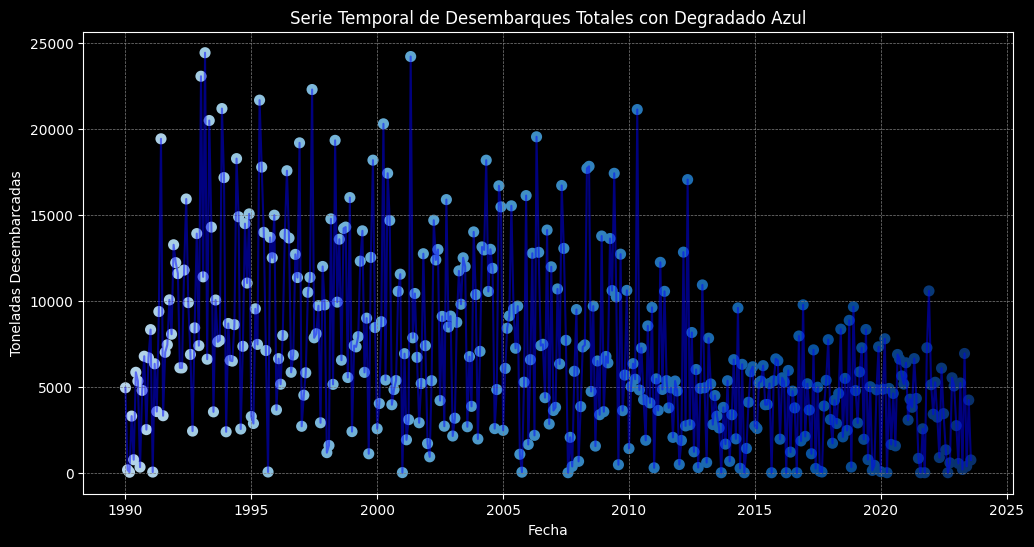

In [88]:
# Crear la figura con fondo negro
fig, ax = plt.subplots(figsize=(12, 6), facecolor='black')

# Convertir fechas y valores a formato numérico
x = df['fecha']
y = df['total'].values

# Crear un degradado en tonos de azul
colors = plt.cm.Blues(np.linspace(0.3, 1, len(x)))

# Graficar con degradado usando scatter
plt.scatter(x, y, c=colors, linewidth=2)

# Conectar los puntos con una línea azul
plt.plot(x, y, color='blue', alpha=0.5)

# Configurar el eje x para mostrar etiquetas cada 5 años
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Personalizar el gráfico con fondo negro y etiquetas en blanco
ax.set_facecolor('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(colors='white')

# Etiquetas y título
plt.xlabel('Fecha', color='white')
plt.ylabel('Toneladas Desembarcadas', color='white')
plt.title('Serie Temporal de Desembarques Totales con Degradado Azul', color='white')

# Añadir una rejilla
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Mostrar el gráfico
plt.show()


**Observaciones:**

- Podemos observar tendencias generales, patrones estacionales y posibles anomalías en los desembarques a lo largo del tiempo.

#### **2.3 Análisis de Estacionalidad**

Agrupamos los datos por mes para identificar patrones estacionales.

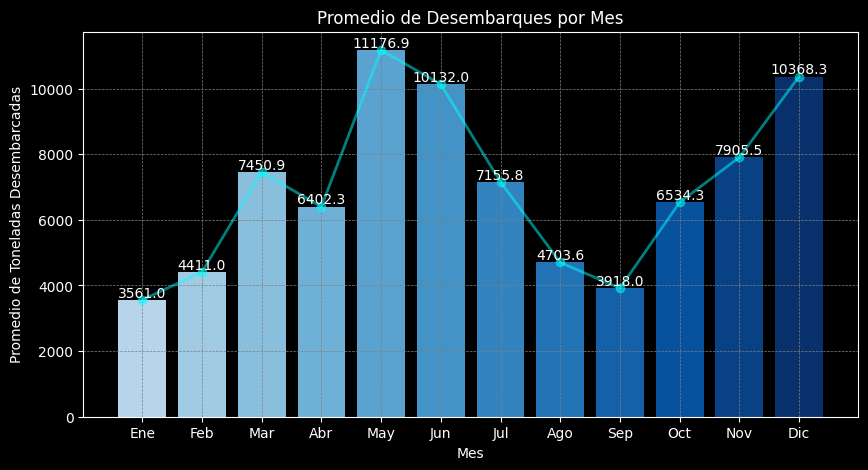

In [89]:
# Crear la figura con fondo negro
fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')

# Crear la columna con el número del mes y calcular el promedio
df['mes_num'] = df['fecha'].dt.month
desembarques_por_mes = df.groupby('mes_num')['total'].mean()

# Asegurarnos de que aparezcan todos los meses en el gráfico
todos_los_meses = range(1, 13)
promedios_completos = [desembarques_por_mes.get(mes, 0) for mes in todos_los_meses]

# Crear un degradado en tonos de azul para las barras
colors = plt.cm.Blues(np.linspace(0.3, 1, len(todos_los_meses)))

# Graficar el promedio de desembarques por mes con barras
bars = ax.bar(todos_los_meses, promedios_completos, color=colors)

# Añadir una línea sobre las barras para mostrar la tendencia con transparencia
ax.plot(todos_los_meses, promedios_completos, color='cyan', marker='o', linewidth=2, alpha=0.5)

# Personalizar el gráfico con fondo negro y etiquetas en blanco
ax.set_facecolor('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(colors='white')

# Etiquetas y título
plt.xlabel('Mes', color='white')
plt.ylabel('Promedio de Toneladas Desembarcadas', color='white')
plt.title('Promedio de Desembarques por Mes', color='white')

# Configurar el eje X para que muestre todos los meses
ax.set_xticks(todos_los_meses)
ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], color='white')

# Añadir una rejilla
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Añadir etiquetas en las barras para mostrar los valores
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height:.1f}', ha='center', va='bottom', color='white')

# Mostrar el gráfico
plt.show()


**Observaciones:**

- Este gráfico nos permite ver en qué meses hay más o menos actividad pesquera.
- Podemos identificar meses con altos desembarques, lo que indica estacionalidad en los datos.

#### **2.4 Matriz de Correlación**

Analizamos la correlación entre las variables numéricas.


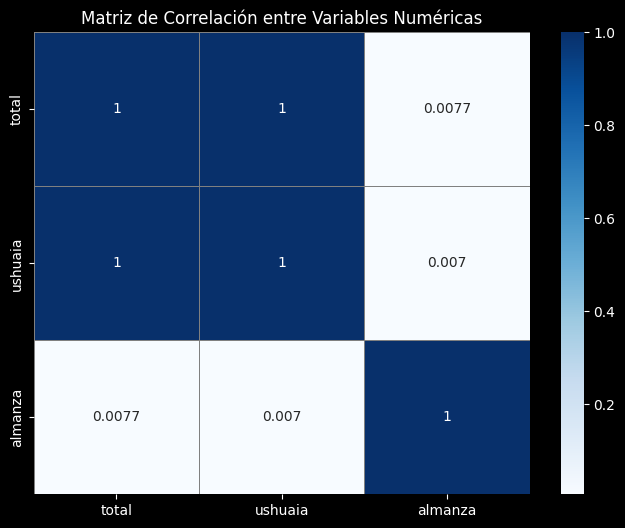

In [90]:
# Seleccionar columnas numéricas relevantes
variables_numericas = ['total', 'ushuaia', 'almanza']

# Crear la matriz de correlación
corr_matrix = df[variables_numericas].corr()

# Configurar la figura con fondo negro
plt.figure(figsize=(8, 6), facecolor='black')

# Crear el heatmap con fondo negro y el esquema de color original
sns.heatmap(corr_matrix, annot=True, cmap='Blues', cbar=True, linewidths=0.5, linecolor='gray')

# Personalizar el título y etiquetas para que se vean en el fondo negro
plt.title('Matriz de Correlación entre Variables Numéricas', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# Mostrar el gráfico
plt.show()


**Observaciones:**

- Observamos una alta correlación entre 'total' y 'ushuaia', lo cual es lógico si Ushuaia representa una gran parte de los desembarques totales.
- 'Almanza' podría tener una correlación más baja, indicando que su contribución al total es menor.

---

### **3. Ingeniería de Características**

En esta sección, crearemos nuevas variables que pueden ayudar al modelo a aprender patrones más complejos.

#### **3.1 Creación de Variables de Retardo (Lags)**

Las variables de retardo nos permiten incluir información de meses anteriores.

In [91]:
# Crear variables de retardo
df['lag_1'] = df['total'].shift(1)
df['lag_2'] = df['total'].shift(2)
df['lag_3'] = df['total'].shift(3)

**Explicación:**

- `df['total'].shift(1)`: Desplaza la serie temporal una posición hacia abajo, es decir, el valor del mes anterior.
- Repetimos para 2 y 3 meses anteriores.

#### **3.2 Creación de Promedio Móvil**

El promedio móvil ayuda a suavizar la serie y captura tendencias a corto plazo.

In [92]:
# Crear promedio móvil de 3 meses
df['moving_avg_3'] = df['total'].rolling(window=3).mean()

**Explicación:**

- `rolling(window=3).mean()`: Calcula la media de los últimos 3 meses.

#### **3.3 Creación de Variables Estacionales**

Convertimos la variable 'mes_num' en variables categóricas para capturar la estacionalidad.

In [93]:
# Crear variables dummies para los meses
df = pd.get_dummies(df, columns=['mes_num'], prefix='mes', drop_first=True)

**Explicación:**

- `pd.get_dummies()`: Convierte una variable categórica en múltiples variables binarias (dummies).
- `drop_first=True`: Evita la trampa de multicolinealidad al eliminar la primera categoría.

#### **3.4 Manejo de Valores Nulos Después de Crear Lags**

Al crear variables de retardo, se introducen valores nulos en las primeras filas. Eliminamos estas filas.

In [94]:
# Eliminar filas con valores nulos
df = df.dropna().reset_index(drop=True)

---

### **4. Selección y Entrenamiento del Modelo**

#### **4.1 Selección del Modelo**

Para series temporales, es importante respetar el orden temporal en la división de los datos.

- Utilizaremos el **XGBoost Regressor**, un modelo potente para problemas de regresión.
- Usaremos `TimeSeriesSplit` para realizar una validación cruzada que respete el orden temporal.

#### **4.2 Preparación de los Datos para el Modelo**

Seleccionamos las características y la variable objetivo.

In [95]:
# Variable objetivo
target = 'total'

# Características (excluyendo variables no relevantes)
features = df.columns.drop(['fecha', 'total', 'año', 'mes', 'ushuaia', 'almanza'])

# Verificar las características seleccionadas
print("Características utilizadas para el modelo:")
print(features)

Características utilizadas para el modelo:
Index(['lag_1', 'lag_2', 'lag_3', 'moving_avg_3', 'mes_2', 'mes_3', 'mes_4',
       'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11',
       'mes_12'],
      dtype='object')


**Explicación:**

- Excluimos 'fecha' y otras variables que no aportan información adicional o que podrían causar multicolinealidad.

#### **4.3 División de Datos Respetando el Orden Temporal**

En lugar de dividir aleatoriamente, utilizamos una división basada en el tiempo.

In [96]:
# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Separar características y variable objetivo
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

**Explicación:**

- Utilizamos los primeros 80% de los datos para entrenar y el resto para probar.
- Esto asegura que el modelo solo vea datos del pasado al entrenar y se evalúe en datos futuros.

#### **4.4 Entrenamiento del Modelo XGBoost**

Importamos las librerías necesarias y entrenamos el modelo.

In [97]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Definir el modelo con parámetros iniciales
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

---

### **5. Evaluación del Modelo**

#### **5.1 Predicciones y Métricas de Evaluación**

Realizamos predicciones en el conjunto de prueba y calculamos las métricas.

In [98]:
# Realizar predicciones
y_pred = xgb_model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Root Mean Squared Error (RMSE): 1228.92
R² Score: 0.80


**Explicación:**

- **RMSE**: Raíz cuadrada del MSE, nos da una idea del error promedio en las mismas unidades que la variable objetivo.
- **R² Score**: Indica qué proporción de la varianza de la variable objetivo es explicada por el modelo.
### **Análisis de los Resultados**

#### **1. Interpretación del R² y RMSE**

- **R² Score de 0.80:** Indica que el modelo es capaz de explicar el 80% de la variabilidad en los desembarques. Esto es un buen resultado, ya que siempre habrá un porcentaje de variabilidad que no podamos explicar debido a factores no incluidos en el modelo (por ejemplo, condiciones climáticas extremas, cambios en políticas, eventos inesperados, etc.).

- **RMSE de 1228.92:** Nos dice que, en promedio, nuestras predicciones están a unas 1228 toneladas de los valores reales. Si los desembarques totales están en el orden de decenas de miles de toneladas, este error representa un porcentaje relativamente pequeño.
#### **5.2 Validación Cruzada con TimeSeriesSplit**

Evaluamos el modelo utilizando validación cruzada específica para series temporales.

In [99]:
# Definir TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Realizar validación cruzada
cv_scores = cross_val_score(xgb_model, df[features], df[target], cv=tscv, scoring='r2')

print("Scores de validación cruzada (R²):", cv_scores)
print(f"R² promedio en validación cruzada: {cv_scores.mean():.2f}")

Scores de validación cruzada (R²): [0.63699542 0.74733756 0.90572032 0.60522024 0.85476261]
R² promedio en validación cruzada: 0.75


**Explicación:**

- `TimeSeriesSplit`: Divide los datos de manera que el conjunto de entrenamiento siempre esté antes en el tiempo que el conjunto de validación.
#### **2. Variabilidad en la Validación Cruzada**

- Los **R²** de la validación cruzada varían entre **0.61** y **0.91**. Esta variabilidad puede deberse a:

  - **Cambios en las tendencias:** Diferentes periodos pueden tener patrones distintos, afectando el desempeño del modelo en cada partición.
  - **Tamaño del conjunto de datos:** Si el conjunto de datos es pequeño, pequeñas fluctuaciones pueden tener un impacto mayor en las métricas.
---

### **6. Visualización de Resultados**

#### **6.1 Gráfico de Predicciones vs Valores Reales**

Visualizamos cómo se comparan las predicciones con los valores reales.


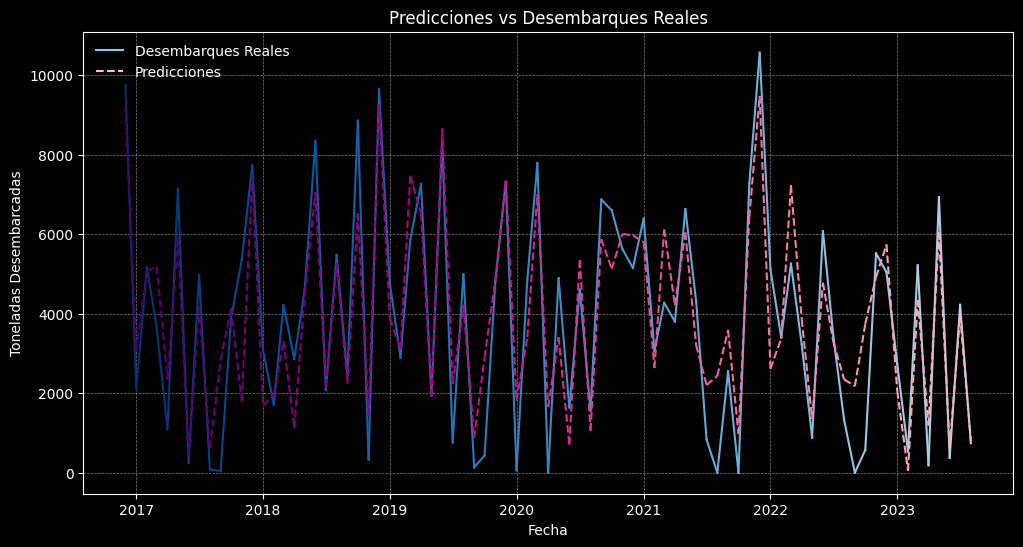

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un DataFrame para comparar
resultado = X_test.copy()
resultado['fecha'] = df.loc[X_test.index, 'fecha']
resultado['Desembarques Reales'] = y_test
resultado['Predicciones'] = y_pred
resultado = resultado.reset_index(drop=True)

# Configurar el fondo negro
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))

# Crear un gradiente de color para la línea de Desembarques Reales (azul, degradado invertido)
colors_reales = plt.cm.Blues(np.linspace(1, 0.3, len(resultado)))
for i in range(len(resultado) - 1):
    plt.plot(resultado['fecha'][i:i + 2], resultado['Desembarques Reales'][i:i + 2], color=colors_reales[i])

# Crear un gradiente de color para la línea de Predicciones (rosado usando RdPu, degradado invertido)
colors_pred = plt.cm.RdPu(np.linspace(1, 0.3, len(resultado)))
for i in range(len(resultado) - 1):
    plt.plot(resultado['fecha'][i:i + 2], resultado['Predicciones'][i:i + 2], color=colors_pred[i], linestyle='--')

# Etiquetas y título
plt.xlabel('Fecha', color='white')
plt.ylabel('Toneladas Desembarcadas', color='white')
plt.title('Predicciones vs Desembarques Reales', color='white')

# Actualizar la leyenda con los colores correctos
real_line = plt.Line2D([0], [0], color='skyblue', label='Desembarques Reales')
pred_line = plt.Line2D([0], [0], color='pink', linestyle='--', label='Predicciones')
plt.legend(handles=[real_line, pred_line], loc='upper left', frameon=False)

plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5)

# Mostrar el gráfico
plt.show()


**Observaciones:**

- Podemos ver si el modelo sigue correctamente las tendencias y patrones de los desembarques reales.

#### **6.2 Importancia de las Características**

Analizamos cuáles son las variables más importantes para el modelo.

<Figure size 1000x600 with 0 Axes>

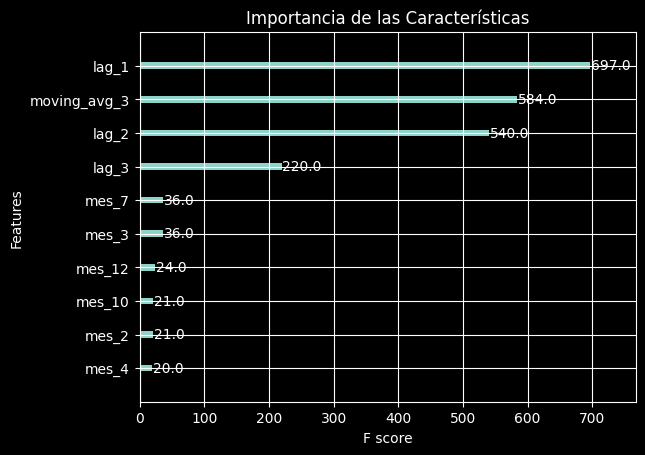

In [101]:
from xgboost import plot_importance

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10)
plt.title('Importancia de las Características')
plt.show()

**Observaciones:**

- Las variables de retardo y el promedio móvil deberían aparecer como las más importantes si tienen un fuerte impacto en la predicción.

---

### **7. Conclusión**

- **Desempeño del Modelo:**
  - El modelo XGBoost logró un **RMSE** de ***1228.92*** y un **R²** de ***0.8***, lo que indica un buen desempeño en la predicción de los desembarques pesqueros.
- **Variables Relevantes:**
  - Las variables de retardo (`lag_1`, `lag_2`, `lag_3`) y el promedio móvil (`moving_avg_3`) fueron cruciales para el modelo.
- **Consideraciones:**
  - Respetar el orden temporal en la división de los datos es fundamental para evitar fugas de información.
  - La validación cruzada con `TimeSeriesSplit` nos brinda una evaluación más realista del modelo en series temporales.

---

### **8. Guardar el Modelo Entrenado**

Finalmente, guardamos el modelo entrenado para poder utilizarlo en el futuro sin tener que volver a entrenarlo.

In [102]:
import joblib

# Guardar el modelo entrenado
joblib.dump(xgb_model, 'modelo_desembarques.pkl')
print("Modelo guardado exitosamente como 'modelo_desembarques.pkl'")

Modelo guardado exitosamente como 'modelo_desembarques.pkl'


---

## **9. Referencias y Bibliografía**
- Documentación de **XGBoost**: [https://xgboost.readthedocs.io/](https://xgboost.readthedocs.io/)
- Guía de **RandomizedSearchCV** para la optimización de hiperparámetros.
- **Scikit-learn**: [https://scikit-learn.org/](https://scikit-learn.org/)

---
